In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
N_KNOT = 30

knots = np.linspace(-0.5, 1.5, N_KNOT)
c = np.random.normal(size=N_KNOT)
spline = sp.interpolate.BSpline(knots, c, 3, extrapolate=False)

x = np.random.uniform(0, 1, 100)
x.sort()
y = spline(x) + np.random.normal(scale=0.25, size=x.size)

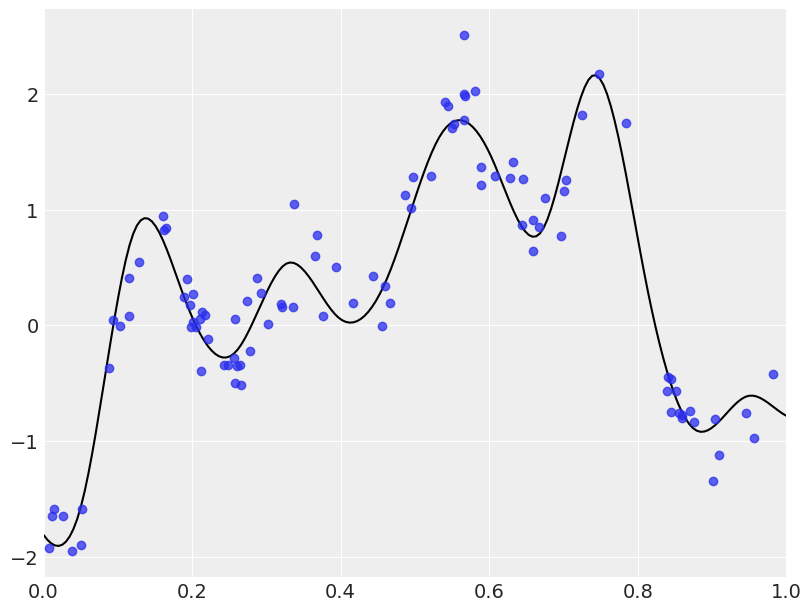

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

x_plot = np.linspace(0, 1, 200)
ax.plot(x_plot, spline(x_plot), c='k')
ax.scatter(x, y, alpha=0.75, zorder=5)
ax.set_xlim(0, 1);

In [5]:
df = pd.DataFrame({"x": x, "y": y})
model = bmb.Model("y ~ bs(x, df=15)", df)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_sigma, bs(x, df = 15), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


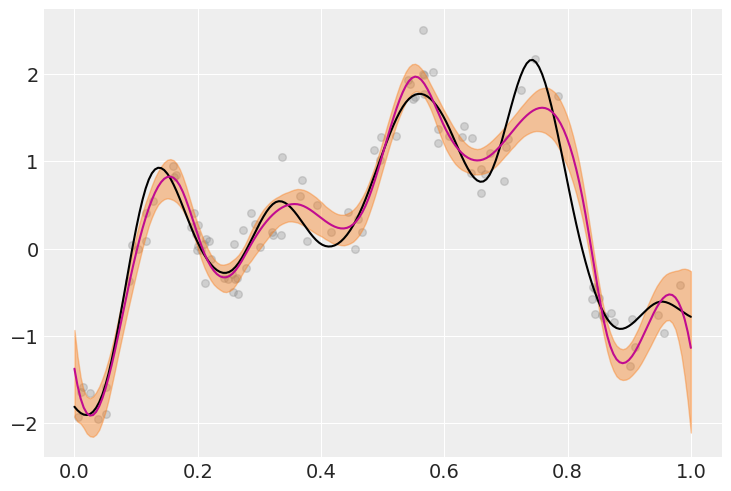

In [6]:
new_data = pd.DataFrame({"x": np.linspace(0, 1, num=200)})
model.predict(idata, data=new_data)

y_pred = idata.posterior.y_mean.values
y_pred_mean = y_pred.mean((0, 1))
hdi_data = np.quantile(y_pred, [0.03, 0.94], axis=(0, 1))

plt.plot(x_plot, spline(x_plot), c='k');

plt.scatter(x, y, alpha=0.3, s=30, color="#888")
plt.plot(new_data["x"], y_pred_mean, color="C3")
plt.fill_between(new_data["x"], hdi_data[0], hdi_data[1], alpha=0.4, color="C1");

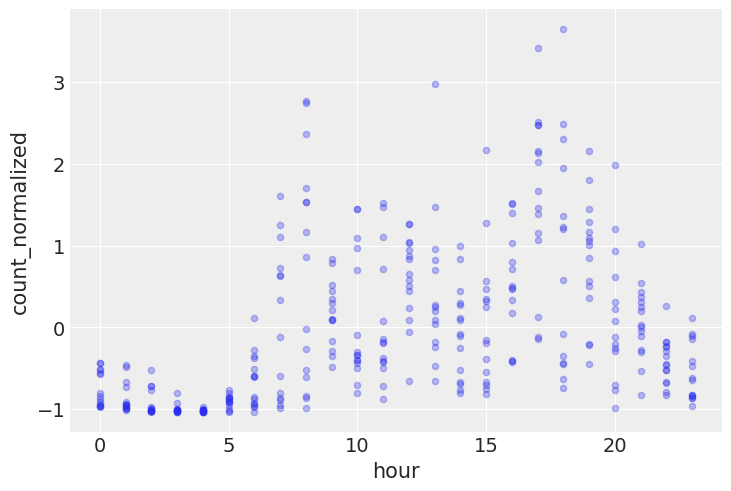

In [7]:
data = pd.read_csv("bikes_hour.csv")
data.sort_values(by="hour", inplace=True)
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]
data.plot(x="hour", y="count_normalized", kind="scatter", alpha=0.3)
data = data.reset_index(drop=True)

In [8]:
knots = np.linspace(0, 23, 8)[1:-1]
model = bmb.Model("count_normalized ~ 0 + bs(hour, knots=knots, intercept=True)", data)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_normalized_sigma, bs(hour, knots = knots, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


One uses HDI by arviz the other computes HDI by hand. The one with Arviz is smoothed

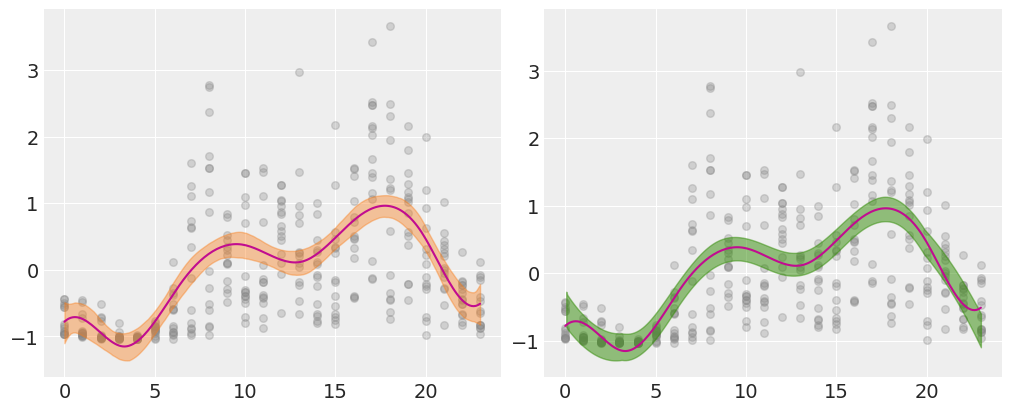

In [9]:
hour = np.linspace(0, 23, num=200)
new_data = pd.DataFrame({"hour": hour})
model.predict(idata, data=new_data)

y_pred = idata.posterior["count_normalized_mean"].values
y_pred_mean = idata.posterior["count_normalized_mean"].values.mean((0, 1))

hdi_data = np.quantile(y_pred, [0.05, 0.94], axis=(0, 1))

_, axes = plt.subplots(1, 2, figsize=(10, 4))


axes[0].scatter(x="hour", y="count_normalized", data=data, alpha=0.3, s=30, color="#888")
axes[0].plot(hour, y_pred_mean, color="C3")
axes[0].fill_between(hour, hdi_data[0],hdi_data[1], alpha=0.4, color="C1")


axes[1].scatter(x="hour", y="count_normalized", data=data, alpha=0.3, s=30, color="#888")
axes[1].plot(hour, y_pred_mean, color="C3")
az.plot_hdi(hour, hdi_data=hdi_data.T, color="C2", ax=axes[1]);